# SIR Model

Description


In [54]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.integrate import odeint


In [64]:
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-covid19-1.2.0.csv') # .0 references the last upload
df = pkg.resource('sd_covid_cases').dataframe().fillna(0)
df.drop(columns=['notes'], inplace=True)
df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['cases_rate'] = df.cases.diff()/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df.rename(columns={'hospitalized': 'hosp'}, inplace=True)
df['hosp_rate'] = df.hosp.diff()/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp, df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['deaths_rate'] = df.deaths.diff()/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths, df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)

sd = df


/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


In [66]:
def make_sir(N, beta, gamma):
    #N = 3.2e6
    S = N - 1
    I = 1
    R = 0
    #beta = 0.6 # infection rate
    #gamma = 0.2 # recovery rate

    def diff(sir, t):
        # sir[0] - S, sir[1] - I, sir[2] - R
        dsdt = - (beta * sir[0] * sir[1])/N
        didt = (beta * sir[0] * sir[1])/N - gamma * sir[1]
        drdt = gamma * sir[1]
        #print (dsdt + didt + drdt)
        dsirdt = [dsdt, didt, drdt]
        return dsirdt


    # initial conditions
    sir0 = (S, I, R)

    # time points
    t = np.linspace(0, 100, num=1000)

    # solve ODE
    # the parameters are, the equations, initial conditions, 
    # and time steps (between 0 and 100)
    sir = odeint(diff, sir0, t)

    df = pd.DataFrame({
        't' : t,
        'S' : sir[:, 0],
        'I' : sir[:, 1],
        'R' : sir[:, 2],
    }).set_index('t')

    df = df.groupby(np.round(df.index).astype(int)).mean()

    df['known_cases'] = (N-df.S)*.15

    # San Diegos data starts with 8 cases, so make that day zero
    day_0_idx = (df.known_cases-8).abs().idxmin()
    df = df.shift(-day_0_idx)

    return df

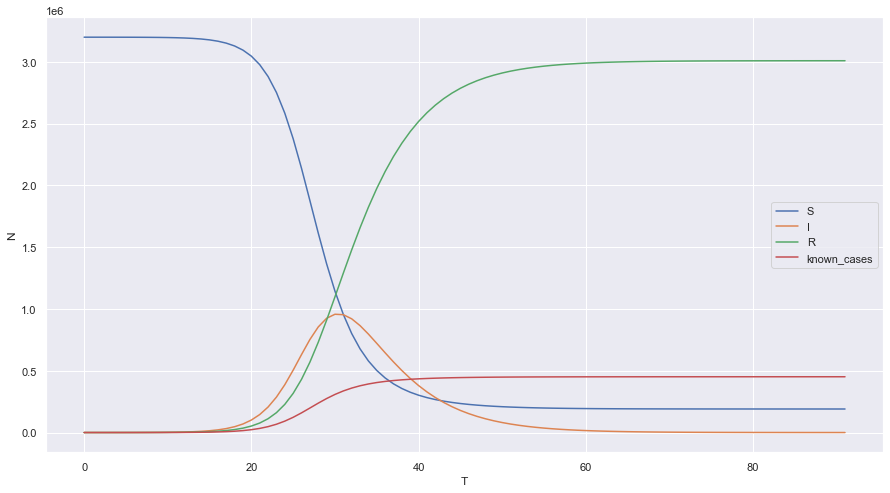

In [68]:
sir = make_sir(3.2e6, .6, .2)

fig, ax = plt.subplots(figsize=(15,8))

sir.plot(ax=ax)

plt.legend()

plt.xlabel('T')
plt.ylabel('N')

# use scientific notation
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

0.5 0.16666666666666666 3.0


(0, 30)

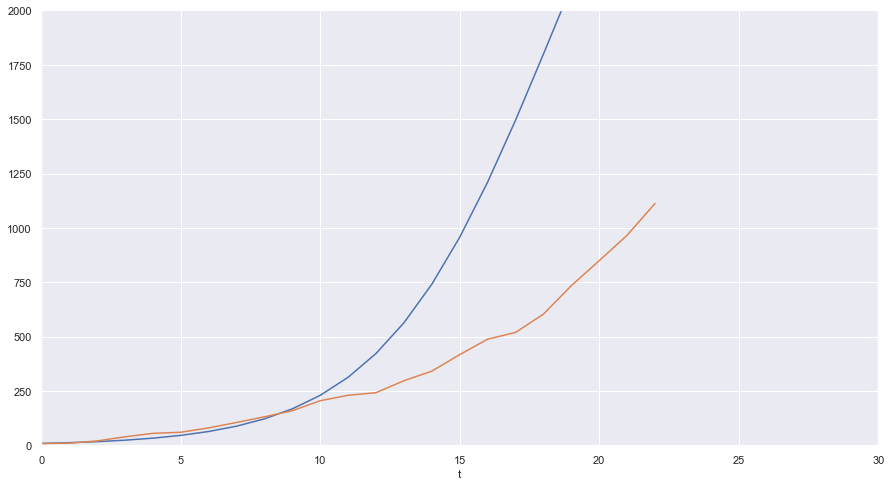

In [131]:
N = 30000
R = 3
beta = .5
gamma = beta / R  # R * beta
print(beta, gamma, beta / gamma)
sir = make_sir(N, beta, gamma)

fig, ax = plt.subplots(figsize=(15,8))

sir.known_cases.plot(ax=ax)

sd.cases.plot()

ax.set_ylim(0,2000)
ax.set_xlim(0,30)

(0, 30)

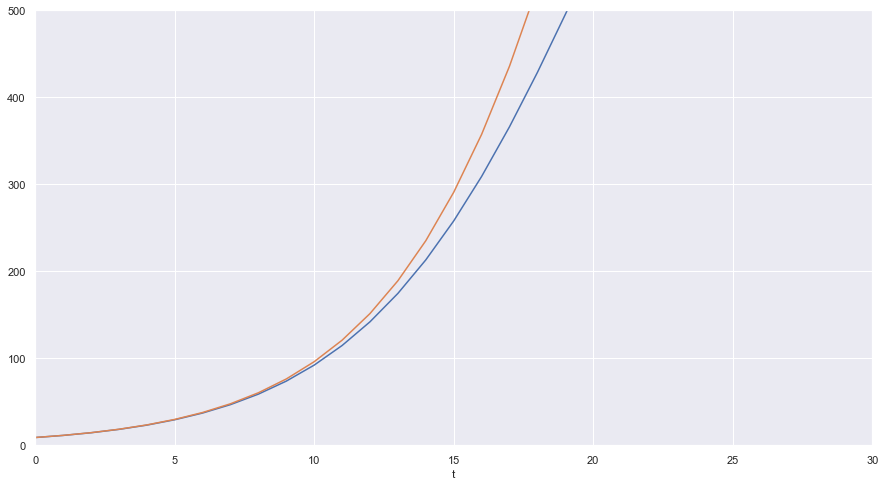

In [120]:
sir1 = make_sir(10000, beta, gamma)
sir2 = make_sir(20000, beta, gamma)

fig, ax = plt.subplots(figsize=(15,8))

sir1.known_cases.plot(ax=ax)
sir2.known_cases.plot(ax=ax)

ax.set_ylim(0,500)
ax.set_xlim(0,30)
